In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Dataset Description
The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

train = train.to_numpy()

In [4]:
print(f"size of train data: {train.shape[0]}")
print(f"size of test data: {test.shape[0]}")

size of train data: 42000
size of test data: 28000


In [5]:
train_data , cross_val =  train_test_split(train, test_size=0.2,  random_state =88)

X_train = train_data[:,1:]
X_val = cross_val[:,1:]
y_train = train_data[:,0].reshape(-1,1)
y_val = cross_val[:,0].reshape(-1,1)

print(f"shape of x_train: {X_train.shape}\t Type of x_train: {type(X_train)}")
print(f"shape of y_train: {y_train.shape}\t Type of y_train: {type(y_train)}\n")
print(f"shape of x_val: {X_val.shape}\t Type of x_val: {type(X_val)}")
print(f"shape of y_val: {y_val.shape}\t Type of y_val: {type(y_val)}")

shape of x_train: (33600, 784)	 Type of x_train: <class 'numpy.ndarray'>
shape of y_train: (33600, 1)	 Type of y_train: <class 'numpy.ndarray'>

shape of x_val: (8400, 784)	 Type of x_val: <class 'numpy.ndarray'>
shape of y_val: (8400, 1)	 Type of y_val: <class 'numpy.ndarray'>


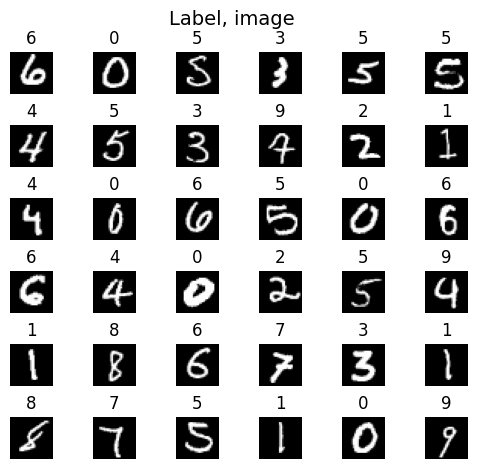

In [6]:
fig,axes = plt.subplots(6,6, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91])

m = X_train.shape[0]


for i,ax in enumerate(axes.flat):
    # selecting random indices
    random_index = np.random.randint(m)
    
    x_random_reshaped = X_train[random_index].reshape(28,28)
    
    ax.imshow(x_random_reshaped, cmap='gray')
    
    ax.set_title(y_train[random_index,0])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=14)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import linear, relu, softmax

In [8]:
tf.random.set_seed(1234) # for consistent results

model = Sequential(
        [
            tf.keras.Input(shape = (784,)),
            tf.keras.layers.Dense(units=25 , activation='relu', name='L1'),
            tf.keras.layers.Dense(units=15 , activation='relu', name='L2'),
            tf.keras.layers.Dense(units=10 , activation='linear', name='L3'),

        ],name="my_model"
)


In [9]:
model.summary()     # L1param --> 784*25(w) + 25(b) = 19625

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 25)             │        19,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,175 (78.81 KB)

 Trainable params: 20,175 (78.81 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
W1,b1 = model.get_layer('L1').get_weights()
W2,b2 = model.get_layer('L2').get_weights()
W3,b3 = model.get_layer('L3').get_weights()

print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (784, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


In [11]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          #logits:z cause tensorflow to lil bit less numerical round off error
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),                         #it tells to use 1/1+e^-z (softmax) in loss func instead "a" calculated softmax in last layer,thats why we use linear activation in last layer
)

history = model.fit(X_train,y_train, epochs=40,validation_data=(X_val, y_val))

Epoch 1/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.2736 - val_loss: 0.9196
Epoch 2/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8061 - val_loss: 0.6115
Epoch 3/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5532 - val_loss: 0.5003
Epoch 4/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4467 - val_loss: 0.4601
Epoch 5/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3925 - val_loss: 0.4283
Epoch 6/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3586 - val_loss: 0.3900
Epoch 7/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3345 - val_loss: 0.3757
Epoch 8/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3278 - val_loss: 0.3476
Epoch 9/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3064 - val_loss: 0.3693
Epoch 10/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2892 - val_loss: 0.3437
Epoch 11/40
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2756 - val_loss: 0.3511
Epoch 12/40
1050/1050 ━━━━━━━━

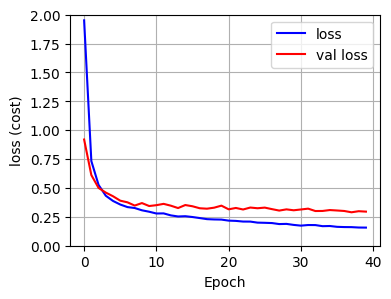

In [12]:
def plot_loss_tf(history):
    fig,ax = plt.subplots(1,1, figsize = (4,3))
    ax.plot(history.history['loss'], label='loss',c='b')
    ax.plot(history.history['val_loss'], label='val loss',c='r')
    ax.set_ylim([0, 2])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('loss (cost)')
    ax.legend()
    ax.grid(True)
    plt.show()
plot_loss_tf(history)

In [13]:
def display_digit(x):
    fig,ax = plt.subplots(1,1, figsize=(1,1))
    x_reshaped = x.reshape(28,28)
    ax.imshow(x_reshaped, cmap='gray')
    plt.show()

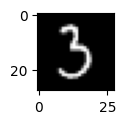

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
prediction: 
[[-20.473913   -1.5890749  -8.01148     5.949526   -7.8288226  -1.5918156
  -12.171215   -5.1087713  -4.300212    1.4468337]]
Largest prediction index: 3


In [14]:
img = X_train[111]
display_digit(img)

prediction = model.predict(img.reshape(1,784))

print(f"prediction: \n{prediction}")
print(f"Largest prediction index: {np.argmax(prediction)}")
# as we using linear activation in L3 output isnt probability

In [15]:
prediction_p = tf.nn.softmax(prediction)

print(f"prediction (probability vector): \n{prediction_p}")
print(f"Total of prediction: {np.sum(prediction_p):0.3f}")

prediction (probability vector): 
[[3.3050806e-12 5.2573031e-04 8.5417702e-07 9.8795193e-01 1.0253566e-06
  5.2429165e-04 1.3335154e-08 1.5566049e-05 3.4940673e-05 1.0945647e-02]]
Total of prediction: 1.000


In [16]:
yhat = np.argmax(prediction_p)          #return max val index
print(f"yhat: {yhat}")

yhat: 3


In [17]:
model.evaluate(X_train,y_train)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1619


0.16236864030361176

In [18]:
model.evaluate(X_val,y_val)

263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2875


0.2952655553817749

In [19]:
def display_error(model, X,y):
    f = model.predict(X)
    yhat = np.argmax(f,axis=1)
    idxs = np.where(yhat != y[:,0])[0]
    error = (len(idxs)/y.shape[0])*100
    print(f"number of error: {len(idxs)}")
    print(f"accurancy: {100-error:0.3f}")
    
display_error(model, X_train,y_train)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
number of error: 1580
accurancy: 95.298


In [20]:
display_error(model, X_val,y_val)

263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
number of error: 556
accurancy: 93.381


In [21]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
Results = model.predict(test)
Results = np.argmax(Results,axis=1)



875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [23]:
subm = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
subm.Label = Results
subm.to_csv('submission.csv', index=False,header=True)